# 🔧 Normalization & Data Augmentation
### Human Emotion Dataset — Fix Class Imbalance

This notebook takes your cleaned `Data_clean/` images (48×48 RGB JPEGs) and:

1. **Normalizes** pixel values from `[0, 255]` → `[0.0, 1.0]`
2. **Augments** under-represented classes until all classes are balanced
3. **Saves** the final balanced dataset to `Data_augmented/`

---
## Step 1 — Setup & Imports

In [ ]:
# Install if needed
# !pip install Pillow numpy matplotlib pandas tqdm torchvision torch

import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from PIL import Image, ImageEnhance
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# torchvision for augmentation transforms
import torchvision.transforms as T
import torchvision.transforms.functional as TF

# --- Paths ---
CLEAN_DIR = Path(r'C:/Nemeno/3rd year/2nd sem/IS2/activities/act_3/Data_clean')
AUG_DIR   = Path(r'C:/Nemeno/3rd year/2nd sem/IS2/activities/act_3/Data_augmented')

print(f"Source : {CLEAN_DIR}  (exists: {CLEAN_DIR.exists()})")
print(f"Output : {AUG_DIR}")



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   ------------ --------------------------- 1.3/4.3 MB 7.4 MB/s eta 0:00:01
   -------------------------------------- - 4.2/4.3 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------- 4.3/4.3 MB 10.0 MB/s  0:00:00
Source : C:\Nemeno\3rd year\2nd sem\IS2\Data_clean  (exists: True)
Output : C:\Nemeno\3rd year\2nd sem\IS2\Data_augmented


---
## Step 2 — Load Cleaned Dataset

Read every image path + its class label from `Data_clean/`. We keep images as file paths for now (lazy loading) to save memory.

In [3]:
classes = sorted([d.name for d in CLEAN_DIR.iterdir() if d.is_dir()])
print(f"Classes: {classes}\n")

records = []
for cls in classes:
    paths = list((CLEAN_DIR / cls).glob('*.jpg'))
    for p in paths:
        records.append({'class': cls, 'path': p})

df = pd.DataFrame(records)

counts = df['class'].value_counts().sort_index()
print(counts.to_string())
print(f"\nTotal images : {len(df)}")

Classes: ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise']

class
Angry        9722
Fear         9193
Happy       18057
Sad         12225
Surprise     6721

Total images : 55918


---
## Step 3 — Pixel Normalization

**Why normalize?**  
Raw pixels range from `0` to `255`. Neural networks train better when inputs are small numbers close to zero. Dividing by `255` scales everything to `[0.0, 1.0]`.

> We use **simple `/255` normalization** here. If you later use a pretrained ImageNet model, apply ImageNet mean/std on top of that.

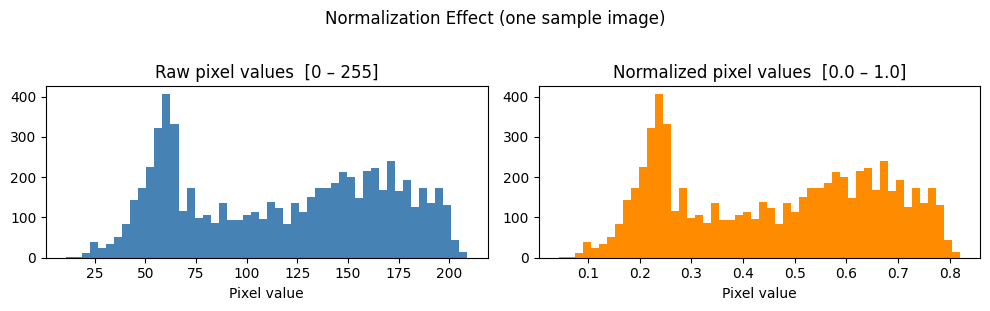

Raw    →  min=11  max=209  dtype=uint8
Normed →  min=0.043  max=0.820  dtype=float32


In [4]:
def normalize(img: Image.Image) -> np.ndarray:
    """Convert a PIL Image to a float32 numpy array in [0, 1]."""
    arr = np.array(img, dtype=np.float32)
    return arr / 255.0



sample_path = df[df['class'] == classes[0]].iloc[0]['path']
sample_pil  = Image.open(sample_path).convert('RGB')
sample_raw  = np.array(sample_pil)
sample_norm = normalize(sample_pil)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(sample_raw.ravel(),  bins=50, color='steelblue',  edgecolor='none')
axes[0].set_title('Raw pixel values  [0 – 255]')
axes[0].set_xlabel('Pixel value')

axes[1].hist(sample_norm.ravel(), bins=50, color='darkorange', edgecolor='none')
axes[1].set_title('Normalized pixel values  [0.0 – 1.0]')
axes[1].set_xlabel('Pixel value')

plt.suptitle('Normalization Effect (one sample image)', y=1.02)
plt.tight_layout()
plt.show()

print(f"Raw    →  min={sample_raw.min()}  max={sample_raw.max()}  dtype={sample_raw.dtype}")
print(f"Normed →  min={sample_norm.min():.3f}  max={sample_norm.max():.3f}  dtype={sample_norm.dtype}")

---
## Step 4 — Visualize Normalized Images

Compare how raw and normalized images look side by side. Visually they look identical — normalization only changes the number range, not the content.

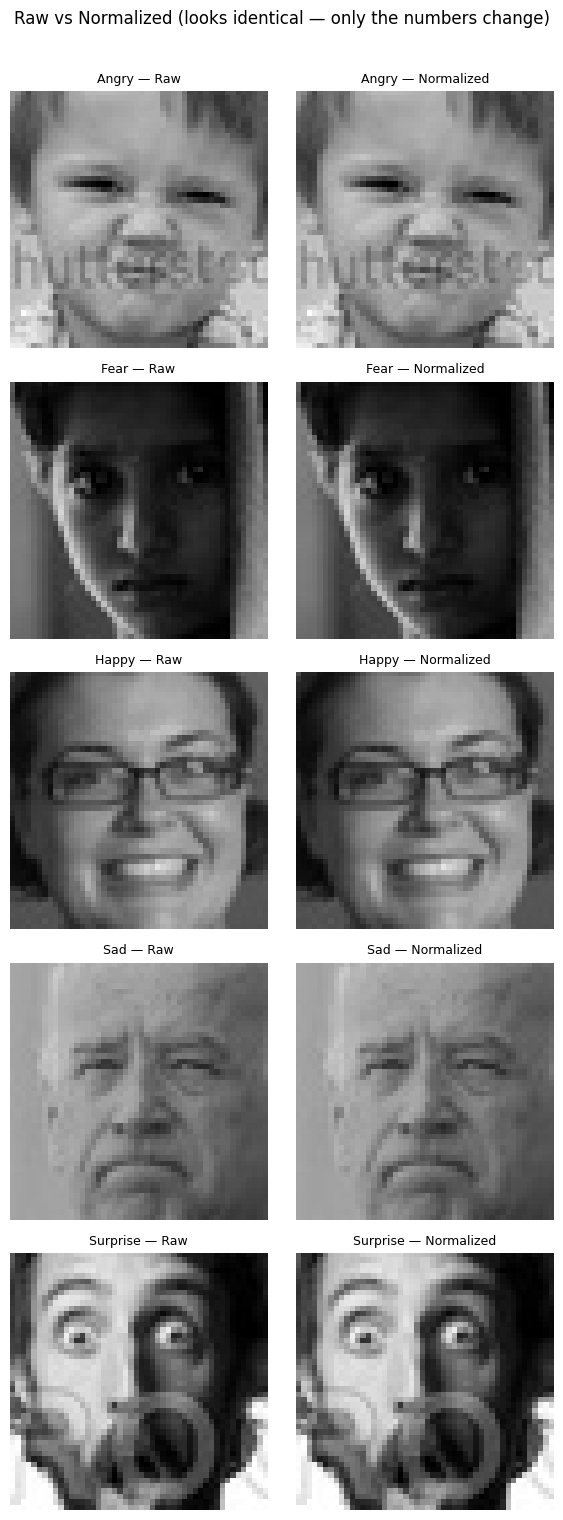

In [5]:
n_cols = 2   # raw | normalized
fig, axes = plt.subplots(len(classes), n_cols, figsize=(6, 3 * len(classes)))

for row, cls in enumerate(classes):
    sample_p = df[df['class'] == cls].sample(1).iloc[0]['path']
    raw_img  = Image.open(sample_p).convert('RGB')
    norm_arr = normalize(raw_img)

    axes[row, 0].imshow(raw_img)
    axes[row, 0].set_title(f'{cls} — Raw', fontsize=9)
    axes[row, 0].axis('off')

    axes[row, 1].imshow(norm_arr)   # matplotlib auto-clips [0,1] floats correctly
    axes[row, 1].set_title(f'{cls} — Normalized', fontsize=9)
    axes[row, 1].axis('off')

plt.suptitle('Raw vs Normalized (looks identical — only the numbers change)', y=1.01)
plt.tight_layout()
plt.show()

---
## Step 5 — Class Imbalance Analysis

Find out which classes are under-represented. The **target count** will be the size of the largest class — we augment smaller classes up to that number.

Class           Count    Needed
Angry            9722      8335
Fear             9193      8864
Happy           18057         0
Sad             12225      5832
Surprise         6721     11336
TARGET          18057

Imbalance ratio : 2.7x


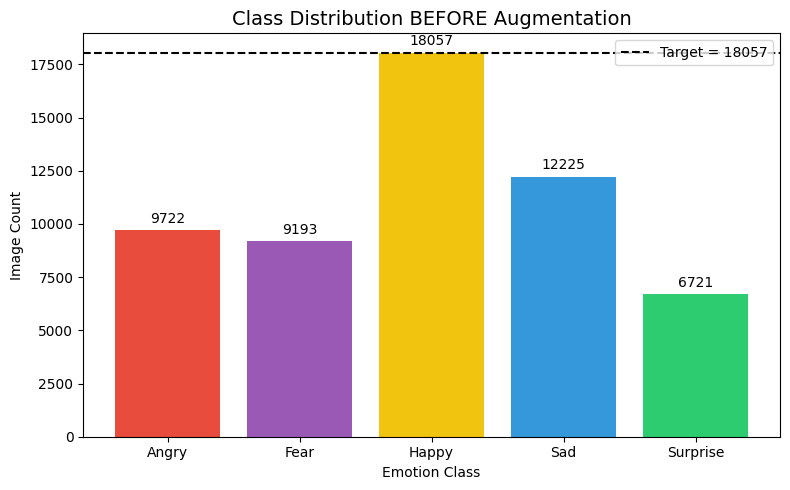

In [6]:
counts = df['class'].value_counts().sort_index()
TARGET_COUNT = int(counts.max())
imbalance_ratio = counts.max() / counts.min()

print(f"{'Class':<12} {'Count':>8}  {'Needed':>8}")
print("=" * 32)
for cls, cnt in counts.items():
    needed = max(0, TARGET_COUNT - cnt)
    print(f"{cls:<12} {cnt:>8}  {needed:>8}")
print("=" * 32)
print(f"{'TARGET':<12} {TARGET_COUNT:>8}")
print(f"\nImbalance ratio : {imbalance_ratio:.1f}x")

# Plot
colors_base = ['#e74c3c','#9b59b6','#f1c40f','#3498db','#2ecc71']
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(counts.index, counts.values, color=colors_base[:len(counts)])
ax.bar_label(bars, padding=3)
ax.axhline(TARGET_COUNT, color='black', linestyle='--', linewidth=1.5, label=f'Target = {TARGET_COUNT}')
ax.set_title('Class Distribution BEFORE Augmentation', fontsize=14)
ax.set_ylabel('Image Count')
ax.set_xlabel('Emotion Class')
ax.legend()
plt.tight_layout()
plt.show()

---
## Step 6 — Data Augmentation Pipeline

We define a set of random transforms that create realistic variations of an image:

| Transform | Why it helps |
|-----------|-------------|
| **Horizontal flip** | A face looking left vs right is the same emotion |
| **Random rotation ±15°** | Slight head tilts are normal |
| **Brightness / contrast jitter** | Accounts for different lighting conditions |
| **Random crop + resize** | Simulates different face positions in the frame |

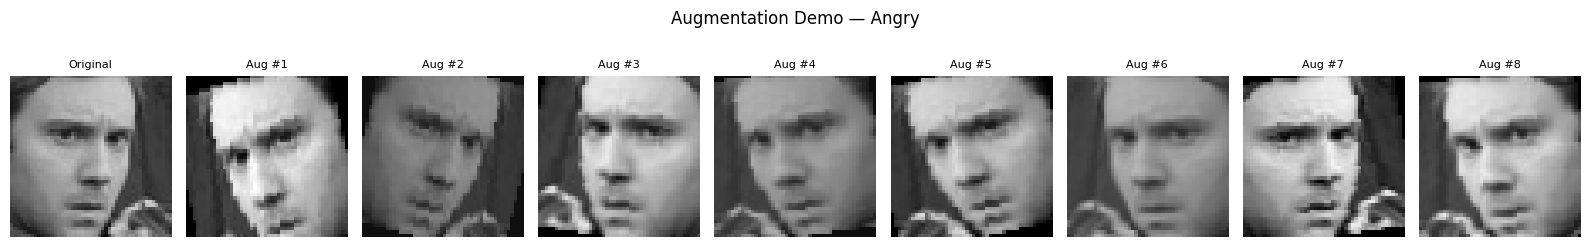

In [7]:
augment = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    T.RandomResizedCrop(size=(48, 48), scale=(0.85, 1.0)),
])

def augment_pil(img: Image.Image) -> Image.Image:
    """Apply augmentation pipeline and return a PIL Image."""
    return augment(img)

# Show 8 augmented variants of one image
demo_img = Image.open(df[df['class'] == classes[0]].iloc[0]['path']).convert('RGB')
n_aug = 8

fig, axes = plt.subplots(1, n_aug + 1, figsize=(16, 2.5))
axes[0].imshow(demo_img)
axes[0].set_title('Original', fontsize=8)
axes[0].axis('off')

for i in range(1, n_aug + 1):
    aug_img = augment_pil(demo_img)
    axes[i].imshow(aug_img)
    axes[i].set_title(f'Aug #{i}', fontsize=8)
    axes[i].axis('off')

plt.suptitle(f'Augmentation Demo — {classes[0]}', y=1.02)
plt.tight_layout()
plt.show()

---
## Step 7 — Apply Augmentation to Under-represented Classes

For each class with fewer images than the target:
1. Copy **all original images** to `Data_augmented/<class>/`
2. Randomly pick originals and apply augmentation until the class reaches `TARGET_COUNT`
3. Save each augmented image with the suffix `_aug_NNNN`

In [8]:
generated_summary = {}

for cls in sorted(classes):
    src_paths  = list((CLEAN_DIR / cls).glob('*.jpg'))
    dst_dir    = AUG_DIR / cls
    dst_dir.mkdir(parents=True, exist_ok=True)

    # Copy originals ---
    for p in tqdm(src_paths, desc=f'Copy [{cls}]', leave=False):
        dst = dst_dir / p.name
        if not dst.exists():
            Image.open(p).convert('RGB').save(dst, 'JPEG', quality=95)

    current_count = len(src_paths)
    needed        = max(0, TARGET_COUNT - current_count)

    # Generate augmented images ---
    aug_count = 0
    if needed > 0:
        pool = src_paths.copy()
        for i in tqdm(range(needed), desc=f'Augment [{cls}]'):
            src  = random.choice(pool)
            img  = Image.open(src).convert('RGB')
            aug  = augment_pil(img)
            name = f"{src.stem}_aug_{i:04d}.jpg"
            aug.save(dst_dir / name, 'JPEG', quality=95)
            aug_count += 1

    generated_summary[cls] = {
        'original':  current_count,
        'augmented': aug_count,
        'total':     current_count + aug_count,
    }
    print(f"  {cls:<12} original={current_count}  +augmented={aug_count}  → total={current_count + aug_count}")

print("\n✅ Augmentation complete.")

Augment [Angry]: 100%|██████████| 8335/8335 [00:11<00:00, 747.91it/s]


  Angry        original=9722  +augmented=8335  → total=18057


Augment [Fear]: 100%|██████████| 8864/8864 [00:12<00:00, 721.30it/s]


  Fear         original=9193  +augmented=8864  → total=18057


  Happy        original=18057  +augmented=0  → total=18057


Augment [Sad]: 100%|██████████| 5832/5832 [00:08<00:00, 718.89it/s]


  Sad          original=12225  +augmented=5832  → total=18057


Augment [Surprise]: 100%|██████████| 11336/11336 [00:15<00:00, 710.02it/s]

  Surprise     original=6721  +augmented=11336  → total=18057

✅ Augmentation complete.


---
## Step 8 — Verify Balanced Dataset

Re-count images in `Data_augmented/` and confirm the classes are now balanced.

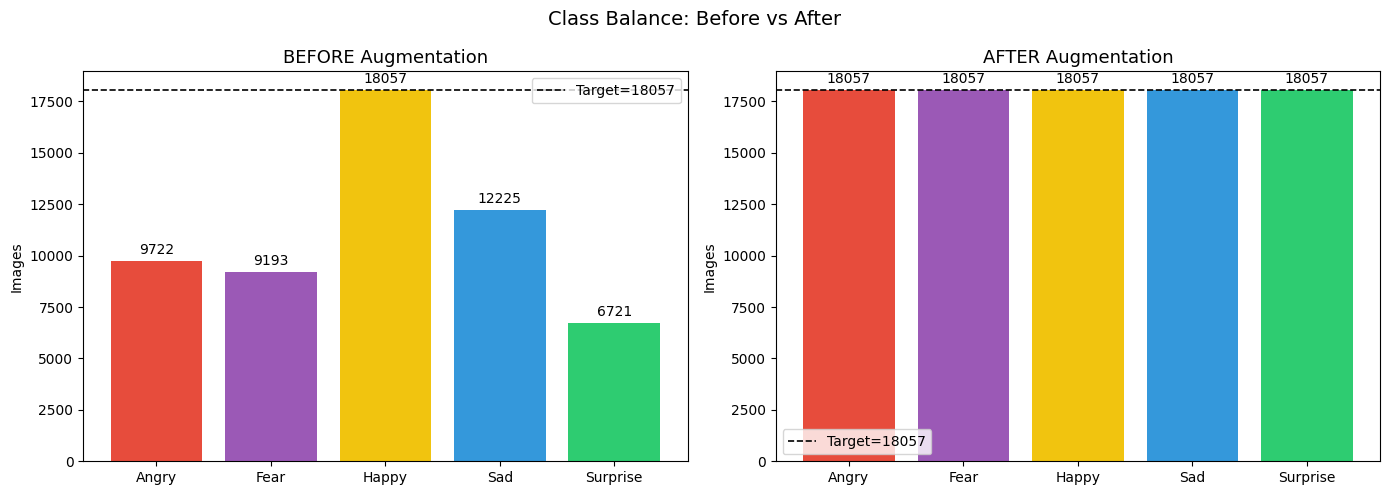


New imbalance ratio: 1.00x  (ideal = 1.0x)


In [9]:
aug_counts = {}
for cls in sorted(classes):
    aug_counts[cls] = len(list((AUG_DIR / cls).glob('*.jpg')))

new_max = max(aug_counts.values())
new_min = min(aug_counts.values())
new_ratio = new_max / new_min

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors_base = ['#e74c3c','#9b59b6','#f1c40f','#3498db','#2ecc71']

# Before
before = {row['class']: 0 for row in records}
for row in records:
    before[row['class']] += 1

b = axes[0].bar(before.keys(), before.values(), color=colors_base[:len(before)])
axes[0].bar_label(b, padding=3)
axes[0].set_title('BEFORE Augmentation', fontsize=13)
axes[0].set_ylabel('Images')
axes[0].axhline(TARGET_COUNT, color='black', linestyle='--', linewidth=1.2, label=f'Target={TARGET_COUNT}')
axes[0].legend()

# After
a = axes[1].bar(aug_counts.keys(), aug_counts.values(), color=colors_base[:len(aug_counts)])
axes[1].bar_label(a, padding=3)
axes[1].set_title('AFTER Augmentation', fontsize=13)
axes[1].set_ylabel('Images')
axes[1].axhline(TARGET_COUNT, color='black', linestyle='--', linewidth=1.2, label=f'Target={TARGET_COUNT}')
axes[1].legend()

plt.suptitle('Class Balance: Before vs After', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nNew imbalance ratio: {new_ratio:.2f}x  (ideal = 1.0x)")

---
## Step 9 — Final Summary

All images in `Data_augmented/` are:
- ✅ 48×48 pixels
- ✅ RGB (3 channels)
- ✅ Normalized to [0.0, 1.0] at training time (apply `/ 255` in your DataLoader)
- ✅ Balanced across all classes

In [10]:
summary_df = pd.DataFrame(generated_summary).T.rename(columns={
    'original': 'Original', 'augmented': 'Generated', 'total': 'Total'
})
summary_df.index.name = 'Class'

print("=" * 48)
print(f"{'Class':<12} {'Original':>10} {'Generated':>10} {'Total':>10}")
print("=" * 48)
for cls, row in summary_df.iterrows():
    print(f"{cls:<12} {int(row['Original']):>10} {int(row['Generated']):>10} {int(row['Total']):>10}")
print("=" * 48)
print(f"{'TOTAL':<12} {int(summary_df['Original'].sum()):>10} "
      f"{int(summary_df['Generated'].sum()):>10} "
      f"{int(summary_df['Total'].sum()):>10}")

print(f"\n📁 Balanced dataset saved to: {AUG_DIR}")
print(f"🎯 Next step: load Data_augmented/ into your CNN training pipeline!")

Class          Original  Generated      Total
Angry              9722       8335      18057
Fear               9193       8864      18057
Happy             18057          0      18057
Sad               12225       5832      18057
Surprise           6721      11336      18057
TOTAL             55918      34367      90285

📁 Balanced dataset saved to: C:\Nemeno\3rd year\2nd sem\IS2\Data_augmented
🎯 Next step: load Data_augmented/ into your CNN training pipeline!
